# Bayesian Optimization: Searching for the global minima
**You should hand in a report, via Canvas, maximum 6 pages (excluding references). 
Do not attach any appendices. In the report you should present your data, models and the final results.
Do not forget to visualize your data and results.
It is important that you discuss your findings and reflect on the results.
In addition you need to hand in your Python code.
The code itself will not be graded, but it should run without errors and upon inspection reproduce the main results you present in the report.
Emphasis will be put on your ability to use appropriate terminology to describe and discuss the employed statistical methodologies and results.**

**<font color=red>DEADLINE: Dec 5 (Tuesday), 23:59</font>**

## Background
In this project you will explore and search the potential energy surface (PES) for an Au atom placed on top of a Au surface.
We will use a gold surface with Miller indices (433), which is so-called vicinal surface, corresponding to stepped (111) surface.
The Au atom  placed ontop of the surface is refered to as an ad-atom.

<img src="images/surface_433.png" alt="Drawing" style="width: 850px;"/>

Here the left image shows a side view of the surface with the ad-atom colored in red.
The right image shows the top view ($z$-direction) of the surface with the primitive cell marked as the smaller rectangle drawn in black.

Finding the position of the ad-atom with the lowest energy is a difficult problem as there are multiple local minima in the PES.
Furthermore, evaluating the potential energy is commonly done with density functional theory (DFT) which is very computationally expensive and hence it is desirable to keep the number of potential energy calculations as low as possible.
To tackle these two problems we will employ Bayesian optimization using Gaussian Processes.

Additional information on a very similar task can be found in the [paper by Todorovic *et al.*](https://doi.org/10.1038/s41524-019-0175-2), a copy of which (`Todorovic-2019.pdf` is included in this directory).

## Atomstic structure
Here, instead of DFT, we will use an embedded medium theory calculator which is provided in [`ase`](https://wiki.fysik.dtu.dk/ase/index.html) or [`asap`](https://wiki.fysik.dtu.dk/asap).
You are given a atomistic surface in `structures/surface_supercell.xyz`, which can be read as
``` python
from ase.io import read
surface = read('structures/surface_supercell.xyz')
```
When searching for the optimal location of the ad-atom we only need to consider positions inside the primitive cell since the PES will be repeating itself if we move outside the primitive cell.
We therefore only consider position in the domain
\begin{equation}
0 < x < 16.65653 \quad  \land \quad 0 < y < 2.884996
\end{equation}


## Evaluating the PES
The ad-atom energy of interest, $E$, is defined as by
\begin{equation}
E = E_\text{ad} - E_\text{surface},
\end{equation}
where $E_\text{ad}$ is the potential energy of the system with the ad-atom present and $E_\text{surface}$ the energy of just the bare surface system.
When evaluating the PES, we consider the surface to be completly rigid and only allow the ad-atom to move.
The energy can thus be written as 
\begin{equation}
E = E(x,y,z),
\end{equation}
where $(x,y,z)$ corresponds to the position of the ad-atom.
Here, we will allow the $z$-coordinate of the ad-atom to relax to its local minima (given $x$ and $y$) and thus only consider the $x-y$ dependency of the energy, meaning we write the energy $E$ as
\begin{equation}
E(x, y) = \min_z E(x, y, z).
\end{equation}
The primary goal of this project is to find the global minimum of the function $E(x, y)$ in as few evaluations of $E(x, y)$ as possible.


## Bayesian Optimization
To this end, we turn to Bayesian optimization using Gaussian processes (GPs).
The idea is to iteratively train a GP to model the energy, $E(x, y)$, and use it to suggest new possible samples.

Let $\mathbf{X}$ be an array of shape $(N, 2)$ containing $(x, y)$ points as rows and $\boldsymbol{E}$ an array of length $N$ with energies corresponding to $E(x,y)$ for each point in $\mathbf{X}$.
First we construct an initial model from a few randomly drawn samples $\mathbf{X}$ and their corresponding energies $\boldsymbol{E}$.       
This allows us to train a GP for the given $\mathbf{X}$ and $\boldsymbol{E}$, which provides both an average value $\mu$ and a standard deviation $\sigma$ for the energy at $(x, y)$.

The next step is to select a new point $(x_\text{new},y_\text{new})$ for sampling.
This is done by finding the point $(x_\text{new},y_\text{new})$ in the domain that maximizes the so-called acquisition function $A(x, y)$.
In this project, we recommend using the lower confidence  bound (LCB) acquisition function, which is defined as 
\begin{equation}
A(x, y) = -\mu (x, y) + \beta \sigma (x,y).
\end{equation}
Here, $\beta$ is a hyperparameter that can be chosen approximately from the range 1 to 5.
A large value of $\beta$ will favor more exploration whereas a smaller value will lead to more exploitation.
* **Exploitation:** Search regions with low mean (low energy)
* **Exploration:** Search regions with high uncertainty/variance
You can also adaptively adjust $\beta$ during the Bayesian optimization.
Can you think of suitable protocols?

A new data point can thus be selected by
\begin{equation}
(x_\text{new}, y_\text{new}) = \arg \max_{x, y} A(x, y)
\end{equation}
Next the energy at this new point, $E(x_\text{new}, y_\text{new})$, is evaluated and added to our samples $\mathbf{X}$ and $\boldsymbol{E}$.
This allows a new GP model to be trained and we can iterate through this procedure until convergence is (hopefully) reached.


## GPy optimization
Setting up your GP model can be achieved using a snippet such as the following
```python
k1 = GPy.kern.RBF(input_dim=2)
k2 = GPy.kern.Bias(input_dim=2)
kernel = k1 + k2
model = GPy.models.GPRegression(x_data, y_data, kernel)
model.optimize()
print(model)
```
Where `model.optimize` will find the variance, length scale and bias that maximizes the log-likelihood for the GP.
The log-likelihood may be very flat or contain multiple local minima.
In case you end up with strange parameters (such as the lengthscale being $10^{-10}$ or $10^{10}$), it can help to rerun the optimization a few times which can automatically be done via
``` python
model.optimize_restarts()
```
Additionaly, it might help to put some reasonable constraints on the parameters, via
```python
k1 = GPy.kern.RBF(input_dim=2)
k1['lengthscale'].constrain_bounded(0.1, 5)
```
Instead of strict constraints, one can also set priors over the parameters via, e.g.,
``` python
k1 = GPy.kern.RBF(input_dim=2)
k1['lengthscale'].set_prior(GPy.priors.Gamma(a=2, b=1))
```

## Helper function for z-relaxation
Below is a helper function that you can use to carry out the relaxation over $z$.
It might be helpful to also define a function only taking $(x, y)$ as argument and setting $z$ to, e.g.,
```python
z = surface.positions[:, 2].max() + 3
```
to make sure the ad-atom sits on top of the surface, and then pass $(x,y,z)$ into `calculate_adatom_energy`.

In [6]:
from ase.constraints import FixAtoms, FixedLine
from ase.optimize import BFGS
from ase import Atom
from asap3 import EMT
# from ase.calculators.emt import EMT


def calculate_adatom_energy(surface, position):
    """Adds adatom to the input surface configuration at the given position
    and relaxes the ad-atoms z-cooridnate.

    Parameters
    ----------
    bare_surface
        surface configuration without adatom
    position
        position (x, y) at which to insert adatom in Ångström

    Returns
    -------
    tuple comprising the energy of the adatom configuration
    """
    
    pos_xyz = np.empty(3)
    pos_xyz[:2] = position
    pos_xyz[-1] = surface.positions[:, 2].max() + 3
    # add adatom
    surface_with_adatom = surface.copy()
    surface_with_adatom.append(Atom('Au', pos_xyz))

    # attach calculator
    calc = EMT()
    surface_with_adatom.set_calculator(calc)

    # apply constraints
    constraints = []
    c = FixAtoms(indices=list(range(len(surface_with_adatom) - 1)))
    constraints.append(c)
    c = FixedLine(-1, [0, 0, 1])
    constraints.append(c)

    # relax configuration
    surface_with_adatom.set_constraint(constraints)
    dyn = BFGS(surface_with_adatom, logfile=None)
    dyn.run(fmax=0.02, steps=200)

    energy_ad = surface_with_adatom.get_potential_energy()    
    
    return energy_ad


def calculate_surf_energy(surface):    
    calc = EMT()
    surface.set_calculator(calc)

    dyn = BFGS(surface, logfile=None)
    dyn.run(fmax=0.02, steps=200)
    energy_surf = surface.get_potential_energy()
    return energy_surf

## Setup
In this project you will need [`ase`](https://wiki.fysik.dtu.dk/ase/index.html), [`asap`](https://wiki.fysik.dtu.dk/asap) and [`GPy`](https://sheffieldml.github.io/GPy/).

In [7]:
import ase
import asap3
import GPy
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read
import pandas as pd
import seaborn as sns

from matplotlib import rc, rcParams
TEXT_SIZE = 12
font = {'family' : 'STIXGeneral',
        'weight' : 'normal',
        'size'   : TEXT_SIZE}
rc('font', **font)
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'

sns.set('talk')
surface = read('structures/surface_supercell.xyz')

## Task 1: Analyzing the PES (1.5p)
The first task of the project will be to generate and visualize the full PES, $E(x, y)$, on a grid for $(x,y)$.
This will give you access to the global minima by visual inspection and will help with understanding, e.g.,  how the optimization algorithms are working or whether they get stuck in the wrong minimum.

This task may take a few minute to run as it requires a lot of evaluations of the PES.

**Tasks:**
* Compute the PES, $E(x, y)$, on a dense grid for $x$ and $y$.
* Visualize the 2D PES as a heatmap.

In [8]:
E_surface = calculate_surf_energy(surface)
x_limits = [0, 16.65653]
y_limits = [0, 2.884996]
step_size = 0.1

x_space = np.arange(*x_limits, step_size)
y_space = np.arange(*y_limits, step_size)

X_1, Y_1 = np.meshgrid(x_space, y_space)
Z_1 = np.zeros(X_1.shape)

for i in range(X_1.shape[0]):
    for j in range(X_1.shape[1]):
        Z_1[i,j] = calculate_adatom_energy(surface, (X_1[i,j], Y_1[i,j])) - E_surface

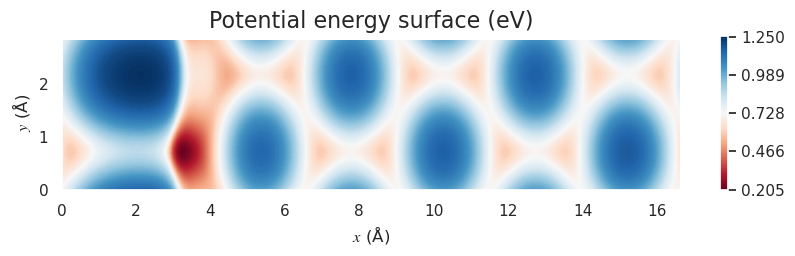

In [9]:
sns.set()
fig, ax = plt.subplots(figsize=(10,2))
c = ax.contourf(X_1, Y_1, Z_1, 250, cmap='RdBu')
Z_1_lims = Z_1.min(), Z_1.max() 
ax.axis([*x_limits, *y_limits])
fig.colorbar(c, ax=ax, ticks=np.linspace(*Z_1_lims, 5))
ax.grid(False)
ax.set_xlabel(r"$x$ (Å)")
ax.set_ylabel(r"$y$ (Å)")
ax.set_title("Potential energy surface (eV)", fontsize=16)
ax.set_facecolor('none')
fig.savefig('task1_pes.jpg', dpi=300, bbox_inches='tight')

## Task 2: Local search (3p)

In this task you will try out local search (gradient descent) and see how it succeeds or fails for our function $E(x,y)$.

For the local search consider a random starting position uniformly drawn from the $\{x,y\}$ domain.

**Tasks:**
* From visual inspection of the PES in Task 1, can you obtain a rough estimate for the percentage of local searches that would end up in the global minimum.
* Run a few (50-500) local searches and record how many ended up in the global minimum.

*Hint:* `scipy.optimize.minimize` can be used

In [11]:
from scipy import optimize    
def pbc_pos(x,y):
    x -= np.floor(x/x_limits[1]) * x_limits[1]
    y -= np.floor(y/y_limits[1]) * y_limits[1]
    return x,y
if False:
    res_pos = []
    res_e   = []
    
    n_searches = 400
    x_gl, y_gl = [], []
    for i in range(n_searches):
        x0 = np.random.uniform(*x_limits)
        y0 = np.random.uniform(*y_limits)
        
        res = optimize.minimize(lambda s: calculate_adatom_energy(surface, s), (x0,y0))
        res_pos.append(res.x)
        res_e.append(res.fun - E_surface)
        if abs(0.2 - (res.fun - E_surface)) < 0.01:
            x_gl.append(x0)
            y_gl.append(y0)

    
    res_x = [p[0] for p in res_pos]
    res_y = [p[1] for p in res_pos]
    
    for i in range(len(res_x)):
        res_x[i], res_y[i] = pbc_pos(res_x[i], res_y[i])
                    
    fig, ax = plt.subplots(ncols=2, figsize=(12,4))
    c = ax[0].scatter(res_x,res_y, c=res_e, s=8, cmap='RdBu', label="Minima")
    ax[0].scatter(x_gl,y_gl, s=1, c='k', label=r"$x_0,y_0 \, \to$ global minimum")
    ax[0].legend()
    h2 = sns.histplot(res_e, ax=ax[1])
    
    fig.colorbar(c)
    ax[0].axis([*x_limits, *y_limits])
    ax[0].set_xlabel(r"$x$ (Å)")
    ax[0].set_ylabel(r"$y$ (Å)")
    
    ax[1].set_xlabel(r"$E$, local minimum")
    
    ax[0].set_title(r"Local searches for global minima", fontsize=16)
    ax[1].set_title(rf"Total searches, $N={n_searches}$", fontsize=16)
    
    fig.tight_layout()
    fig.savefig('task2_local_search.jpg', dpi=300, bbox_inches='tight')

## Task 3: Bayesian optimization (8p)
Implement your own Bayesian optimization algorithm (using GPy for the Gaussian process part) and run it to find the global minima of $E(x, y)$.

Use the [RBF kernel](https://gpy.readthedocs.io/en/deploy/GPy.kern.src.html#module-GPy.kern.src.rbf) and include a Bias kernel if it is needed.

Suitable $\beta$ values might be in the range 1 to 5.

Start the Bayesian optimization from five (5) randomly drawn samples.        


**Tasks:**
* Given the PES in Task 1 choose and motivate priors for the lengthscale and variance parameters in the RBF kernel.
* Run Bayesian optimization and analyze how the choice of $\beta$ influences convergence. Select a good value for $\beta$.
* Rerun bayesian optimization with the selected $\beta$. How many iterations are needed until the global minimum is reached?
* Visualize the PES, the uncertainty ($\sigma$) and the acquisition function together with your samples for the final model.
* In what regions is the final GP model the most uncertain? Why?


*Hints:*
* If your algorithm gets stuck sampling the same points over and over again, try increasing $\beta$ (more exploration).         
* To find the argmax of $A(x, y)$ you can either evaluate it on a very dense grid or run multiple local searches (starting from random positions) and take the maximum obtained.

In [12]:
def acquisition_fn(x,y, model, beta=3):
    X = np.array([x,y]).reshape(1,2)
    mu, var = model.predict(X)
    return -mu + beta * np.sqrt(var)

def new_position(model, beta=3):
    init_pos = (np.random.uniform(*x_limits),  np.random.uniform(*y_limits))
    A = lambda pos: -acquisition_fn(*pos, model, beta)
    res = optimize.minimize(A, init_pos)
    new_pos = pbc_pos(*res.x)    
    return np.array(new_pos)

In [13]:
# from scipy.stats import gamma
# xx = np.linspace(0,5,50)
# yy = gamma.pdf(xx,1.1)
# plt.plot(xx,yy)

In [26]:
def gpy_model(n_samples=120, beta=3):
    X0 = np.array((np.random.uniform(*x_limits, 5),  np.random.uniform(*y_limits, 5))).T
    E0 = np.array([calculate_adatom_energy(surface, xy) - E_surface for xy in X0])
    np.bool = np.bool_
    k1 = GPy.kern.RBF(input_dim=2)
    k2 = GPy.kern.Bias(input_dim=2)
    k1['lengthscale'].set_prior(GPy.priors.Gamma(a=2, b=1))
    k1['variance'].set_prior(GPy.priors.Gamma(a=1.2, b=1))
    k2['variance'].set_prior(GPy.priors.Gamma(a=1.5, b=1))
    kernel = k1 + k2

    model = GPy.models.GPRegression(X=X0, Y=E0.reshape(-1,1), kernel=kernel)
    model.optimize_restarts(verbose=False)

    for i in range(n_samples):
        X_new = new_position(model, beta=beta)
        E_new = calculate_adatom_energy(surface, X_new) - E_surface

        X0 = np.vstack([X0, X_new])    
        E0 = np.hstack([E0, E_new])

        model = GPy.models.GPRegression(X0, E0.reshape(-1,1), kernel=kernel)
        if i % 15 == 0:
            model.optimize_restarts(verbose=False)
        else:
            model.optimize()  
    return model
beta_3=3
model_3 = gpy_model(beta=beta_3)

reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.variance
reconstraining parameters bias.variance


In [27]:
step_size = 0.1

x_space = np.arange(*x_limits, step_size)
y_space = np.arange(*y_limits, step_size)

X_3, Y_3 = np.meshgrid(x_space, y_space)
E_model_3 = np.zeros(X_3.shape)
var_model = np.zeros(X_3.shape)
acq = np.zeros(X_3.shape)

for i in range(X_3.shape[0]):
    for j in range(X_3.shape[1]):
        E_model_3[i,j], var_model[i,j] = model_3.predict(np.array([X_3[i,j], Y_3[i,j]]).reshape(1,2))
        acq[i,j] = acquisition_fn(X_3[i,j], Y_3[i,j], model_3, beta=beta_3)

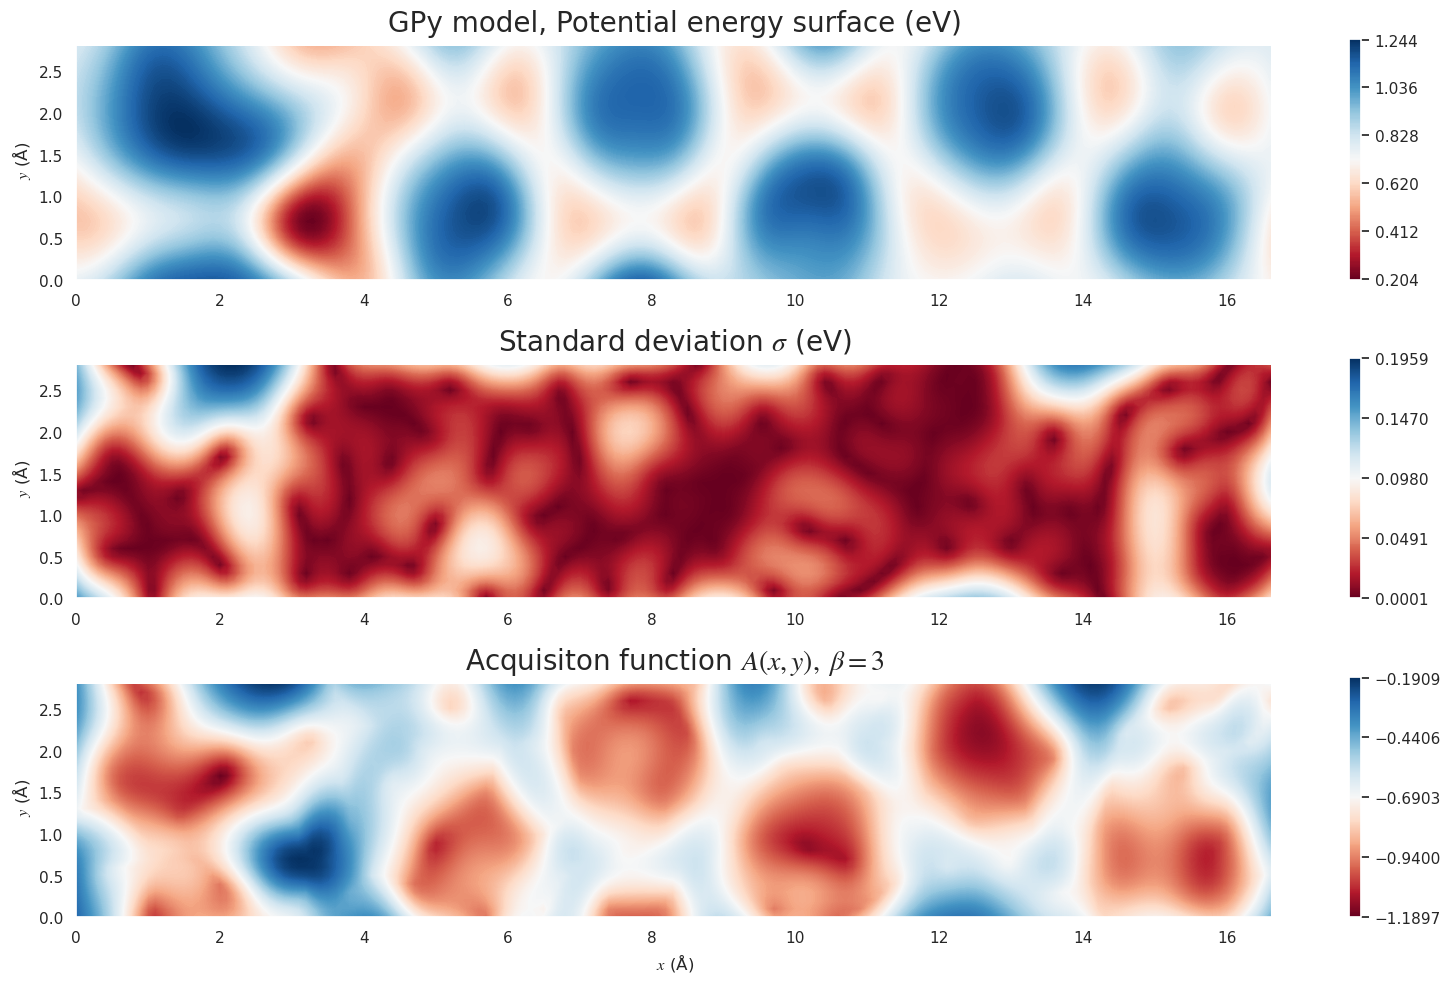

In [28]:
sns.set()
fig, ax = plt.subplots(nrows=3, figsize=(16,10))

c = ax[0].contourf(X_3, Y_3, E_model_3, 250, cmap='RdBu')

cb = fig.colorbar(c, ax=ax[0], ticks=np.linspace(E_model_3.min(), E_model_3.max(), 6))
model_sigma = np.sqrt(var_model)
c = ax[1].contourf(X_3, Y_3, model_sigma, 250, cmap='RdBu')

c_ticks = np.linspace(model_sigma.min(), model_sigma.max(), 5)
fig.colorbar(c, ax=ax[1], ticks=c_ticks)

c = ax[2].contourf(X_3, Y_3, acq, 250, cmap='RdBu')

c_ticks = np.linspace(acq.min(), acq.max(), 5)
fig.colorbar(c, ax=ax[2], ticks=c_ticks)


ax[-1].set_xlabel(r"$x$ (Å)")
for a in ax:
    a.set_ylabel(r"$y$ (Å)")
    a.axis([*x_limits, *y_limits])
    a.set_facecolor('none')

ax[0].set_title("GPy model, Potential energy surface (eV)", fontsize=20)
ax[1].set_title("Standard deviation $\sigma$ (eV)", fontsize=20)
ax[2].set_title(rf"Acquisiton function $A(x,y), \, \, \beta={beta_3}$", fontsize=20)


fig.tight_layout()
fig.savefig('task3_pes.jpg', dpi=300, bbox_inches='tight')

## Task 4: Transition paths barriers (5p)
In Bayesian optimization the low energy regions of the parameter space $(x, y)$ are of interest and thus get sampled more by the acquisition function.    
Next we look at using GPs as a general purpose potential/model for the full PES.
In principle once one has a fast and accurate model over the entire PES we could compute various properties of the ad-atom, such as diffusion barriers and thermodynamic properties.

Here you will look at the energy landscape along a linear path between the global minima and the local energy minimum around $(11, 2.1)$.
To construct the linear path from the initial state to the final state we can write
\begin{equation}
(x, y) = (x_{start}, y_{start}) + \lambda ( x_{end} -x_{start}, y_{end}-y_{start})
\end{equation}
where $\lambda$ should be varied between $0 \to 1$ to span the path.

In this task you will construct a general purpose GP to model the PES and compute the energy along the transition path described above.
This may require 100 to 200 or more training samples.
Use $(x_\text{start}, y_\text{start})$ and $(x_\text{end}, y_\text{end})$ plus a few random samples as a starting point and then iterativley construct a GP model using a suitable acquisition function.

**Tasks:**
* Train a general purpose GP model.
* Compute the error (e.g., [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation)) of the model evaluated over the entire PES using data from Task 1 as a function of training samples. How many samples are needed to get a "good" model in your opinion?
* Use the GP model to compute the energy and its uncertainty along the linear path between the initial and final state. Compare with the GP model obtained in Task 3, and compare with the correct energy along the path computed with EMT. Discuss your findings.


*Hint:* To train a general purpose model one can use the LCB acquisition function and let $\beta \to \infty$.

In [29]:
step_size = 0.1

x_space = np.arange(*x_limits, step_size)
y_space = np.arange(*y_limits, step_size)

X_tst, Y_tst = np.meshgrid(x_space, y_space)
X_fl, Y_fl = X_tst.flatten(), Y_tst.flatten()

E_ = np.zeros(X_fl.shape)

pos_test = np.array([X_fl, Y_fl]).reshape(-1,2)


for i in range(len(E_)):
    E_[i] = calculate_adatom_energy(surface, pos_test[i,:]) - E_surface

def RMSE_model(model):
    mu, _ = model.predict(pos_test)
    E_model = np.array(mu).reshape(-1)
    sq_errors = (E_ - E_model)**2
    
    return np.sqrt(np.mean(sq_errors))

In [68]:
beta_4 = 100
def general_model(n_samples, return_RMSE=False):
    RMSEs = []
    save_every_n=25
    X0 = np.array((np.random.uniform(*x_limits, 5),  np.random.uniform(*y_limits, 5))).T
    E0 = np.array([calculate_adatom_energy(surface, xy) - E_surface for xy in X0])
    k1 = GPy.kern.RBF(input_dim=2)
    k2 = GPy.kern.Bias(input_dim=2)
    k1['lengthscale'].set_prior(GPy.priors.Gamma(a=2, b=1))
    k1['variance'].set_prior(GPy.priors.Gamma(a=1.2, b=1))
    k2['variance'].set_prior(GPy.priors.Gamma(a=1.5, b=1))
    kernel = k1 + k2
    
    model = GPy.models.GPRegression(X=X0, Y=E0.reshape(-1,1), kernel=kernel)
    model.optimize_restarts(verbose=False)

    for i in range(n_samples):
        X_new = new_position(model, beta=beta_4)
        E_new = calculate_adatom_energy(surface, X_new) - E_surface

        X0 = np.vstack([X0, X_new])    
        E0 = np.hstack([E0, E_new])

        model = GPy.models.GPRegression(X0, E0.reshape(-1,1), kernel=kernel)
        if i % 15 == 0:
            model.optimize_restarts(verbose=False)
        else:
            model.optimize()  
        
        if i % save_every_n == 0 and return_RMSE:
            RMSEs.append(RMSE_model(model))
            
    model.optimize_restarts(verbose=False)
    if return_RMSE: 
        RMSEs.append(RMSE_model(model))
        return np.array(RMSEs)
    return model

In [70]:
import warnings
warnings.filterwarnings('ignore')

RMSE_arr = general_model(450, True)

reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.variance
reconstraining parameters bias.variance


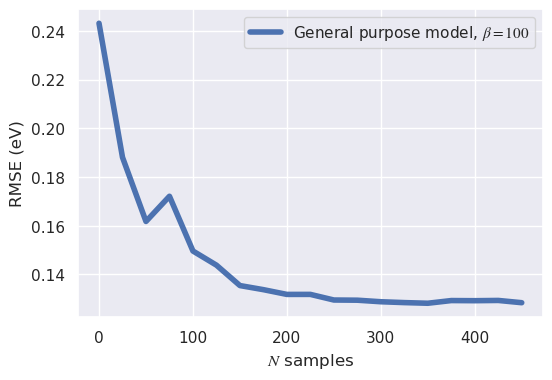

In [84]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(np.arange(0,475,25), RMSE_arr, lw=4, label=r"General purpose model, $\beta=100$")
ax.set_xlabel(r"$N$ samples")
ax.legend()
ax.set_ylabel("RMSE (eV)")
fig.savefig("task4_samples.jpg", bbox_inches='tight', dpi=250)

In [56]:
model_4 = general_model(300)
step_size = 0.05

x_space = np.arange(*x_limits, step_size)
y_space = np.arange(*y_limits, step_size)

X, Y = np.meshgrid(x_space, y_space)
E_model_ = np.zeros(X.shape)
var_model_ = np.zeros(X.shape)
acq_ = np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        E_model_[i,j], var_model_[i,j] = model_4.predict(np.array([X[i,j], Y[i,j]]).reshape(1,2))
        acq_[i,j] = acquisition_fn(X[i,j], Y[i,j], model_4, beta=beta_4)

reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.variance
reconstraining parameters bias.variance


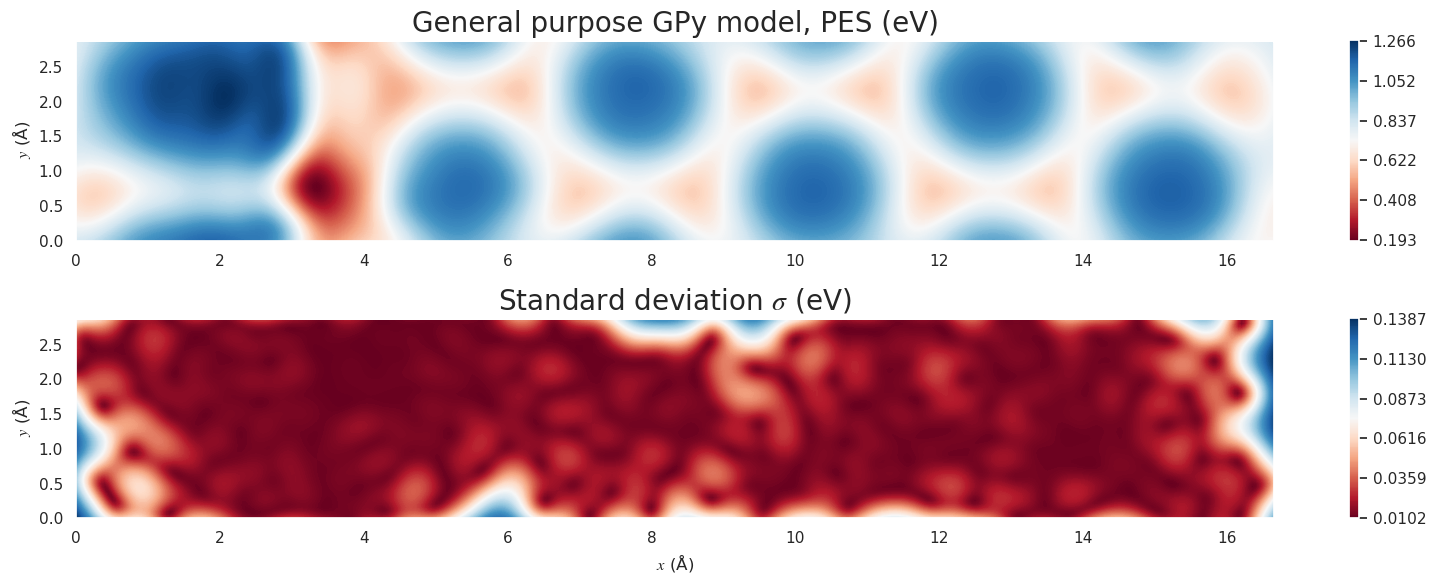

In [57]:
fig, ax = plt.subplots(nrows=2, figsize=(16,6))
c = ax[0].contourf(X, Y, E_model_, 250, cmap='RdBu')
fig.colorbar(c, ax=ax[0], ticks=np.linspace(E_model_.min(), E_model_.max(), 6))

model_sigma_ = np.sqrt(var_model_)
c = ax[1].contourf(X, Y, model_sigma_, 250, cmap='RdBu')
fig.colorbar(c, ax=ax[1], ticks=np.linspace(model_sigma_.min(), model_sigma_.max(), 6))

ax[-1].set_xlabel(r"$x$ (Å)")
for a in ax:
    a.set_ylabel(r"$y$ (Å)")
    a.axis([*x_limits, *y_limits])
    a.set_facecolor('none')


ax[0].set_title("General purpose GPy model, PES (eV)", fontsize=20)
ax[1].set_title("Standard deviation $\sigma$ (eV)", fontsize=20)

fig.tight_layout()
fig.savefig('task4_pes.jpg', dpi=300, bbox_inches='tight')

In [58]:
i_min_e = np.unravel_index(E_model_3.argmin(), E_model_3.shape)
lowest_E_xy = X_3[i_min_e], Y_3[i_min_e]

n_line = 150
lambda_space = np.linspace(0,1,n_line)
line_path = np.array([lowest_E_xy + l * (np.array((11, 2.1)) - np.array(lowest_E_xy)) for l in lambda_space])

f_model_3 = [np.zeros((n_line,1)), np.zeros((n_line,1))]
f_model_4 = [np.zeros((n_line,1)), np.zeros((n_line,1))]
f_EMT = np.zeros(n_line)

f_model_3[0][:], f_model_3[1][:] = model_3.predict(line_path)
f_model_4[0][:], f_model_4[1][:] = model_4.predict(line_path)

mu_3, sigma_3 = f_model_3[0].reshape(-1), np.sqrt(f_model_3[1].reshape(-1))
mu_4, sigma_4 = f_model_4[0].reshape(-1), np.sqrt(f_model_4[1].reshape(-1))

for i in range(n_line):   
    f_EMT[i] = calculate_adatom_energy(surface, line_path[i,:]) - E_surface    

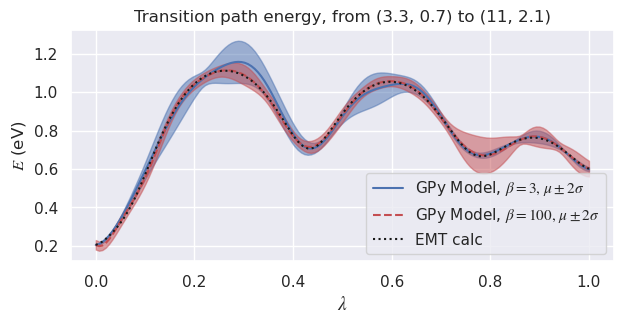

In [59]:
fig, ax = plt.subplots(figsize=(7,3))                        
    
ax.plot(lambda_space, f_model_3[0], 'b', label=rf"GPy Model, $\beta={beta_3}, \, \mu \pm 2\sigma$")
plt.fill_between(lambda_space, mu_3 + 2 * sigma_3, mu_3 - 2 * sigma_3 , color='b', alpha=0.5)

ax.plot(lambda_space, f_model_4[0], '--r', label=rf"GPy Model, $\beta={beta_4}, \, \mu \pm 2\sigma$")
plt.fill_between(lambda_space, mu_4 + 2 * sigma_4, mu_4 - 2 * sigma_4, color='r', alpha=0.5)
             
ax.plot(lambda_space, f_EMT, ':k', label="EMT calc")
ax.legend()
ax.set_xlabel(r"$\lambda$", fontsize=14)
ax.set_ylabel(r"$E$ (eV)")
ax.set_title(f"Transition path energy, from ({X_3[i_min_e]:.1f}, {Y_3[i_min_e]:.1f}) to (11, 2.1)", fontsize=12)

fig.savefig("task4_gpy.jpg", dpi=300, bbox_inches="tight")